## Занятие 7: Докинг низкомолекулярных лигандов в структуру белка

### Лев Мазаев, мАДБМ18

### Загрузка модулей

In [1]:
import numpy as np

# Loading Open Drug Discovery Toolkit
import oddt
import oddt.docking

# Structure and Viewing
from Bio.PDB import *
from ipywidgets import VBox
import nglview as nv
import IPython.display as ipd

RDKit WARNING: [14:59:35] Enabling RDKit 2019.09.2 jupyter extensions


_ColormakerRegistry()

In [2]:
def viewer(*args):
    # функция для трехмерного отображения моделей
    models = []
    for pdb in args:
        v = nv.show_structure_file(pdb)
        v._remote_call('setSize', target='Widget', args=['800px', '600px'])
        v.representations = [
            {"type": "cartoon", "params": {"sele": "protein", "color": "residueindex"}},
            {"type": "ball+stick", "params": {"sele": "ligand"}}
        ]
        models.append(v)
    return(VBox(models))

### Подготовка белка

Визуализируем структуру белка с лигандом:

In [3]:
view1 = viewer('lys_pig_ligand.B99990002.pdb')
view1

Загрузим структуру и посмотрим остатки:

In [4]:
parser = PDBParser()
pdb = parser.get_structure('lys_pig_ligand', 'lys_pig_ligand.B99990002.pdb')

for res in pdb.get_residues():
    if res.id[1] > 140:
        print(res)

<Residue ILE het=  resseq=141 icode= >
<Residue ARG het=  resseq=142 icode= >
<Residue GLY het=  resseq=143 icode= >
<Residue CYS het=  resseq=144 icode= >
<Residue LYS het=  resseq=145 icode= >
<Residue LEU het=  resseq=146 icode= >
<Residue NAG het=H_NAG resseq=147 icode= >
<Residue NAG het=H_NAG resseq=148 icode= >
<Residue NDG het=H_NDG resseq=149 icode= >


147-149 остатки в структуре - лиганд. Создадим отдельные объекты белка и лиганда, визуализируем их:

In [5]:
class NonHetSelect(Select):
    
    def accept_residue(self, residue):
        return 1 if residue.id[0] == ' ' else 0
    
class HetSelect(Select):
    
    def accept_residue(self, residue):
        return 0 if residue.id[0] == ' ' else 1
    
io = PDBIO()
io.set_structure(pdb)
io.save('protein.pdb', NonHetSelect())
io.save('ligand.pdb', HetSelect())

view2 = viewer('protein.pdb', 'ligand.pdb')
view2

Найдем геометрический центр лиганда:

In [6]:
ligand = parser.get_structure('ligand', 'ligand.pdb')
atom_coords = []

for atom in ligand.get_atoms():
    v = atom.get_vector()
    atom_coords.append(v.get_array())
    
geom_center = np.mean(atom_coords, axis=0)
print(geom_center)

[46.8601162  32.48079069 31.7858138 ]


### Подготовка белка для докинга

In [7]:
protein = next(oddt.toolkit.readfile('pdb', 'protein.pdb'))
protein.OBMol.AddPolarHydrogens()
protein.OBMol.AutomaticPartialCharge()

True

In [8]:
print(f'Is it protein? {protein.protein}')
print(f'Molecular weight: {round(protein.molwt, 3)}')
protein.protein = True  # исправим

Is it protein? False
Molecular weight: 16475.905


### Лиганды для докинга

Отобразим исходный лиганд:

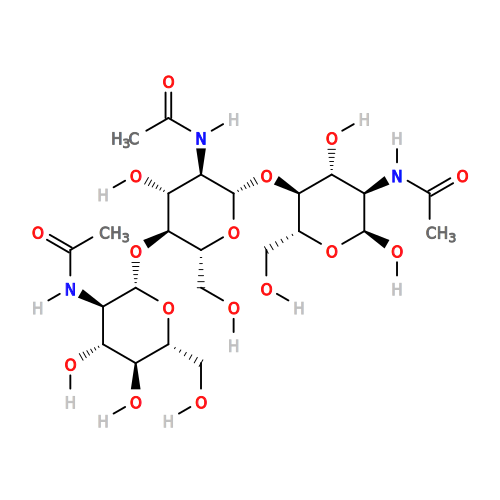

In [9]:
ligand = next(oddt.toolkit.readfile('pdb', 'ligand.pdb'))
ligand.OBMol.AddPolarHydrogens()
ligand.OBMol.AutomaticPartialCharge()
ipd.SVG(ligand.write('svg', opt={'d': None, 'P': 500}))

По заданию не совсем понятно, нужно провести докинг только модифицированного NAG или всего лиганда целиком (NAG-NAG-NDG) с модифицированными NAG. Решил сделать второе. Исходная SMILES-формула:

In [10]:
ligand.smiles

'[C@@H]1([C@@H]([C@H]([C@@H]([C@@H](CO)O1)O)O)NC(=O)C)O[C@H]1[C@@H]([C@H]([C@@H](O[C@@H]1CO)O[C@H]1[C@@H]([C@H]([C@H](O[C@@H]1CO)O)NC(=O)C)O)NC(=O)C)O'

### Докинг

In [ ]:
dock_obj = oddt.docking.AutodockVina.autodock_vina(
    protein=protein, size=(20, 20, 20), center=geom_center,
    executable='/home/leo/Software/vina/vina', autocleanup=True, num_modes=8
)